In [215]:
import pandas as pd
import numpy as np

# Set a seed for reproducibility
np.random.seed(42)

# Number of rows in the dataset
n_rows = 500

# --- 1. Base Columns (No Missing Data) ---
data = {
    'id': range(1, n_rows + 1),
    'age': np.random.randint(18, 70, size=n_rows),
    'city': np.random.choice(['New York', 'London', 'Paris', 'Tokyo', 'Berlin'], size=n_rows, p=[0.3, 0.25, 0.2, 0.15, 0.1]),
    'has_subscription': np.random.choice([True, False], size=n_rows, p=[0.6, 0.4])
}
df = pd.DataFrame(data)

# --- 2. Numerical Column with MCAR: `sensor_reading` ---
# Generate some sensor data
df['sensor_reading'] = np.random.normal(loc=100, scale=20, size=n_rows).round(2)
# Introduce MCAR missingness (approx 15%)
mcar_indices_sensor = np.random.choice(df.index, size=int(n_rows * 0.15), replace=False)
df.loc[mcar_indices_sensor, 'sensor_reading'] = np.nan

# --- 3. Categorical Column with MCAR: `preferred_device` ---
df['preferred_device'] = np.random.choice(['Phone', 'Tablet', 'Laptop', 'Desktop'], size=n_rows, p=[0.4, 0.2, 0.3, 0.1])
# Introduce MCAR missingness (approx 10%)
mcar_indices_device = np.random.choice(df.index, size=int(n_rows * 0.10), replace=False)
df.loc[mcar_indices_device, 'preferred_device'] = np.nan

# --- 4. Numerical Column with NMAR: `reported_income` ---
# True income (hypothetical, not directly in final dataset in this form)
# Let's make true income somewhat related to age for realism, but the NMAR part is key
true_income = 20000 + (df['age'] * 500) + np.random.normal(0, 15000, n_rows)
true_income[true_income < 10000] = 10000 # Floor income
df['reported_income'] = true_income.round(0)

# NMAR mechanism: People with very high or very low incomes are less likely to report
# Define thresholds based on the 'true_income' distribution
low_income_thresh = np.percentile(true_income, 15)  # Bottom 15%
high_income_thresh = np.percentile(true_income, 85) # Top 15%

# Probabilities of missing
prob_missing_low_income = 0.70  # 70% chance of missing if income is low
prob_missing_high_income = 0.60 # 60% chance of missing if income is high
prob_missing_mid_income = 0.05  # 5% chance for others

for i in df.index:
    # Use the 'true_income' for the decision, then make 'reported_income' missing
    actual_val = true_income[i] # The value that would have been reported
    if actual_val < low_income_thresh:
        if np.random.rand() < prob_missing_low_income:
            df.loc[i, 'reported_income'] = np.nan
    elif actual_val > high_income_thresh:
        if np.random.rand() < prob_missing_high_income:
            df.loc[i, 'reported_income'] = np.nan
    else:
        if np.random.rand() < prob_missing_mid_income:
            df.loc[i, 'reported_income'] = np.nan


# --- 5. Categorical Column with NMAR: `satisfaction_level` ---
# True satisfaction (hypothetical)
true_satisfaction = np.random.choice(['Very Unsatisfied', 'Unsatisfied', 'Neutral', 'Satisfied', 'Very Satisfied'],
                                     size=n_rows, p=[0.1, 0.15, 0.3, 0.3, 0.15])
df['satisfaction_level'] = true_satisfaction

# NMAR mechanism: People who are 'Very Unsatisfied' are less likely to report their satisfaction
prob_missing_very_unsatisfied = 0.75 # 75% chance of missing if 'Very Unsatisfied'
prob_missing_other_satisfaction = 0.05 # 5% for other categories

for i in df.index:
    actual_val = true_satisfaction[i] # The value that would have been reported
    if actual_val == 'Very Unsatisfied':
        if np.random.rand() < prob_missing_very_unsatisfied:
            df.loc[i, 'satisfaction_level'] = np.nan
    else:
        # Small chance of missing for other categories too, to make it less obvious
        if np.random.rand() < prob_missing_other_satisfaction:
             df.loc[i, 'satisfaction_level'] = np.nan

# --- Verification ---
print("Dataset head:")
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)

print("\n--- Verifying NMAR ---")
# For reported_income (Numerical NMAR)
# We expect more NaNs where true_income was low or high
# This is a bit tricky to verify directly without the 'true_income' column,
# but we designed it that way. We can look at the distribution of non-missing values.
if 'reported_income' in df.columns and df['reported_income'].isnull().any():
    print("\nReported Income (Numerical NMAR):")
    print("Distribution of non-missing reported_income:")
    print(df['reported_income'].dropna().describe())
    # If NMAR worked, the tails of the original distribution should be underrepresented.

# For satisfaction_level (Categorical NMAR)
# We expect 'Very Unsatisfied' to be underrepresented in non-missing values,
# and a higher proportion of its original occurrences to be NaN.
if 'satisfaction_level' in df.columns and df['satisfaction_level'].isnull().any():
    print("\nSatisfaction Level (Categorical NMAR):")
    print("Value counts of non-missing satisfaction_level:")
    print(df['satisfaction_level'].dropna().value_counts(normalize=True))
    print("\nOriginal (true) distribution of satisfaction_level (for comparison):")
    print(pd.Series(true_satisfaction).value_counts(normalize=True))
    # We expect 'Very Unsatisfied' to have a lower proportion in the non-missing data
    # than in the original 'true_satisfaction' data.

# Check that not all columns have missing values
if df.isnull().all().any():
    print("\nERROR: At least one column has ALL values missing, which shouldn't happen.")
elif not df.isnull().any().all():
    print("\nSUCCESS: Not all columns have missing values.")
else:
    print("\nERROR: All columns have at least one missing value.")


# Check number of columns with missing values
cols_with_missing = df.isnull().any()
num_cols_with_missing = cols_with_missing.sum()
print(f"\nNumber of columns with missing values: {num_cols_with_missing}")
if num_cols_with_missing >= 4:
    print("SUCCESS: At least 4 columns have missing values.")
else:
    print(f"FAILURE: Expected at least 4 columns with missing values, got {num_cols_with_missing}.")

# Verify specific column types and missingness patterns
print("\nSummary of designed missingness:")
print("- sensor_reading (Numerical MCAR): Missingness should be random.")
print("- preferred_device (Categorical MCAR): Missingness should be random.")
print("- reported_income (Numerical NMAR): Missingness depends on its own unobserved value (higher for very low/high incomes).")
print("- satisfaction_level (Categorical NMAR): Missingness depends on its own unobserved value (higher for 'Very Unsatisfied').")

# To save to CSV:
# df.to_csv("dataset_with_missing_values.csv", index=False)
# print("\nDataset saved to dataset_with_missing_values.csv")

Dataset head:
   id  age    city  has_subscription  sensor_reading preferred_device  \
0   1   56  Berlin              True          110.46           Laptop   
1   2   69   Paris             False           88.53           Tablet   
2   3   46   Paris              True             NaN           Tablet   
3   4   32   Paris              True          142.85            Phone   
4   5   60  London             False          134.55          Desktop   

   reported_income satisfaction_level  
0          50307.0            Neutral  
1              NaN        Unsatisfied  
2          17233.0     Very Satisfied  
3          40273.0            Neutral  
4              NaN            Neutral  

Missing values per column:
id                      0
age                     0
city                    0
has_subscription        0
sensor_reading         75
preferred_device       50
reported_income       112
satisfaction_level     57
dtype: int64

Data types:
id                      int64
age            

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [217]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [218]:
df.head()

,id,age,city,has_subscription,sensor_reading,preferred_device,reported_income,satisfaction_level
0,1,56,Berlin,True,110.46,Laptop,50307.0,Neutral
1,2,69,Paris,False,88.53,Tablet,NaN,Unsatisfied
2,3,46,Paris,True,NaN,Tablet,17233.0,Very Satisfied
3,4,32,Paris,True,142.85,Phone,40273.0,Neutral
4,5,60,London,False,134.55,Desktop,NaN,Neutral


In [219]:
df.isnull().mean()*100

id                     0.0
age                    0.0
city                   0.0
has_subscription       0.0
sensor_reading        15.0
preferred_device      10.0
reported_income       22.4
satisfaction_level    11.4
dtype: float64

In [220]:
# handling missing vals in satisfaction level

df['satisfaction_level'].value_counts()

satisfaction_level
Satisfied           148
Neutral             138
Unsatisfied          76
Very Satisfied       68
Very Unsatisfied     13
Name: count, dtype: int64

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  500 non-null    int64  
 1   age                 500 non-null    int32  
 2   city                500 non-null    object 
 3   has_subscription    500 non-null    bool   
 4   sensor_reading      425 non-null    float64
 5   preferred_device    450 non-null    object 
 6   reported_income     388 non-null    float64
 7   satisfaction_level  443 non-null    object 
dtypes: bool(1), float64(2), int32(1), int64(1), object(3)
memory usage: 26.0+ KB


In [222]:
ddf = df

In [223]:
# removing the missing vals from the target

ddf.dropna(subset=['satisfaction_level'], inplace=True)

In [224]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 443 entries, 0 to 499
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  443 non-null    int64  
 1   age                 443 non-null    int32  
 2   city                443 non-null    object 
 3   has_subscription    443 non-null    bool   
 4   sensor_reading      380 non-null    float64
 5   preferred_device    401 non-null    object 
 6   reported_income     339 non-null    float64
 7   satisfaction_level  443 non-null    object 
dtypes: bool(1), float64(2), int32(1), int64(1), object(3)
memory usage: 26.4+ KB


In [225]:
df['has_subscription'] =df['has_subscription'].astype('object')

In [335]:
# train test split
x = ddf.iloc[:, 0:-1]
y = ddf.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [336]:
x_train.isnull().mean()*100

id                   0.000000
age                  0.000000
city                 0.000000
has_subscription     0.000000
sensor_reading      14.361702
preferred_device     9.042553
reported_income     23.138298
dtype: float64

In [337]:
x_train['preferred_device'].value_counts()

preferred_device
Phone      139
Laptop      97
Tablet      71
Desktop     35
Name: count, dtype: int64

In [338]:
# encoding the x cols

tnf1 = ColumnTransformer([
    ('tnf1', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), ['preferred_device', 'city']),
    ('tnf3', OrdinalEncoder(categories=[[False, True]]), ['has_subscription'])
], remainder='passthrough')

In [339]:
# Multivar imputation 

tnf2 = ColumnTransformer([
    ('tnf2', IterativeImputer(n_nearest_features=5, max_iter=50), slice(1, 13))
], remainder='passthrough')

In [340]:
# KNN imputer (backup)

tnf4 = ColumnTransformer([
    ('tnf2', KNNImputer(n_neighbors=5, weights='distance'), slice(1, 13))
], remainder='passthrough')

In [341]:
# Scaling the features

tnf5 = ColumnTransformer([
    ('scale', StandardScaler(), slice(0, 13))
])

In [342]:
# Pipeline to streamline

pipe1 = Pipeline(steps=[
    ('tnf1', tnf1),
    ('tnf2', tnf2),
    ('tnf3', tnf3),
    ('tnf5', tnf5)
])


pipe2 = Pipeline(steps=[
    ('tnf1', tnf1),
    ('tnf4', tnf4),
    ('tnf3', tnf3),
    ('tnf5', tnf5)
])

In [343]:
trfd_train = pipe1.fit_transform(x_train)
trfd_test = pipe1.transform(x_test)

In [344]:
print(np.isnan(trfd_train).sum())

0


In [345]:
label = LabelEncoder()

In [346]:
trfd_ytrain = label.fit_transform(y_train)
trfd_ytest = label.transform(y_test)

## Iterartive

In [364]:
clf = LogisticRegression(max_iter=10000)
clf2 = DecisionTreeClassifier()
clf3 = RandomForestClassifier(max_features='log2', n_estimators=100, max_depth=100)
clf4 = GradientBoostingClassifier()


clf.fit(trfd_train, trfd_ytrain)
clf2.fit(trfd_train, trfd_ytrain)
clf3.fit(trfd_train, trfd_ytrain)
clf4.fit(trfd_train, trfd_ytrain)

pred = clf.predict(trfd_test)
pred2 = clf2.predict(trfd_test)
pred3 = clf3.predict(trfd_test)
pred4 = clf4.predict(trfd_test)

print(accuracy_score(trfd_ytest, pred))
print(accuracy_score(trfd_ytest, pred2))
print(accuracy_score(trfd_ytest, pred3))
print(accuracy_score(trfd_ytest, pred4))


0.31343283582089554
0.31343283582089554
0.373134328358209
0.2835820895522388


In [365]:
print(np.mean(cross_val_score(estimator=clf, X=trfd_train, y=trfd_ytrain, cv=10)))
print(np.mean(cross_val_score(estimator=clf2, X=trfd_train, y=trfd_ytrain, cv=10)))
print(np.mean(cross_val_score(estimator=clf3, X=trfd_train, y=trfd_ytrain, cv=10)))
print(np.mean(cross_val_score(estimator=clf4, X=trfd_train, y=trfd_ytrain, cv=10)))

0.31899004267425324
0.22076813655761024
0.2603840682788051
0.25000000000000006


In [332]:
trfd_train = pipe2.fit_transform(x_train)
trfd_test = pipe2.transform(x_test)

## KNN

In [352]:
clf = LogisticRegression(max_iter=10000)
clf2 = DecisionTreeClassifier()
clf3 = RandomForestClassifier()

clf.fit(trfd_train, trfd_ytrain)
clf2.fit(trfd_train, trfd_ytrain)
clf3.fit(trfd_train, trfd_ytrain)

pred = clf.predict(trfd_test)
pred2 = clf2.predict(trfd_test)
pred3 = clf3.predict(trfd_test)

print(accuracy_score(trfd_ytest, pred))
print(accuracy_score(trfd_ytest, pred2))
print(accuracy_score(trfd_ytest, pred3))


0.31343283582089554
0.31343283582089554
0.373134328358209


<Axes: xlabel='satisfaction_level'>

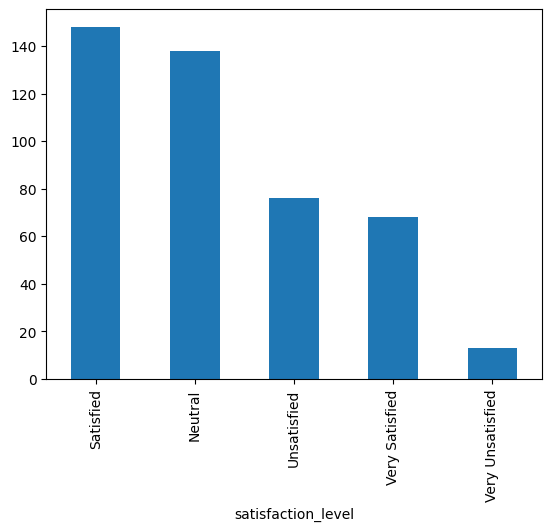

In [350]:
ddf['satisfaction_level'].value_counts().plot(kind='bar')